In [27]:
# Importing libraries

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer


In [12]:
normalized_data = pd.read_csv('../data/bookings_dataset_normalized.csv')
hotel_dataset = pd.read_csv('../data/hotel_bookings.csv')

## Clustering

### PCA Analysis

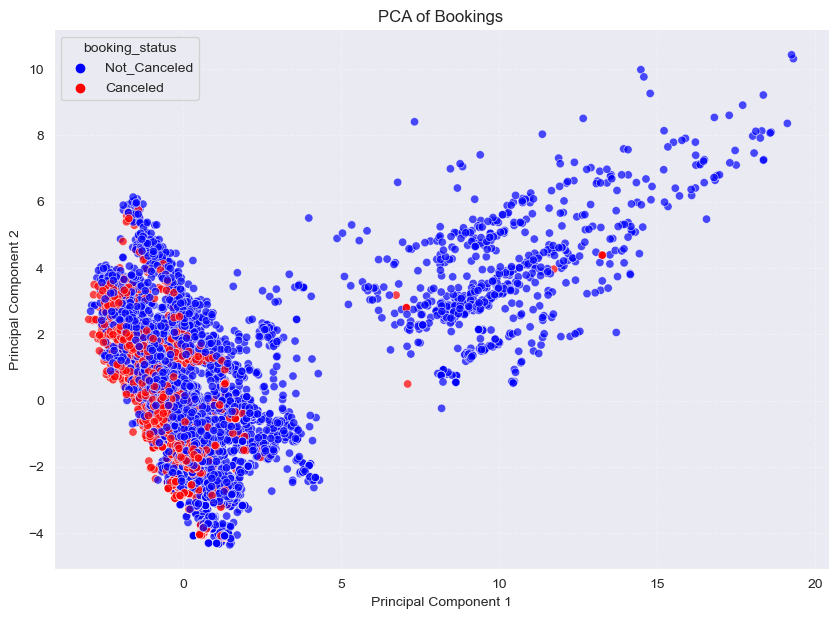

In [13]:
# Separate features and target
X = normalized_data.drop(columns=['booking_status', 'row_id'])  # only numeric features
y = normalized_data['booking_status']

# Run PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)

# Create PCA DataFrame
bookings_pca = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
bookings_pca['booking_status'] = y

# Plot
fig, ax = plt.subplots(figsize=(10, 7))

sns.scatterplot(
    data=bookings_pca,
    x='PC1', 
    y='PC2', 
    hue='booking_status',
    palette={'Canceled': 'red', 'Not_Canceled': 'blue'},
    alpha=0.7,
    ax=ax
)

ax.set_title('PCA of Bookings')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.grid(axis='both', linestyle='--', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()



PCA transformation was performed to facilitate further clustering and enhance cluster visualization. This step helps reduce dimensionality while retaining the most significant variance in the data, making subsequent clustering analysis more effective and interpretable.

The graph illustrating the distribution of canceled and non-canceled bookings across the first two principal components reveals that canceled bookings are relatively rare and scattered in the upper right corner of the plot. This distribution lacks a clear separation boundary, suggesting that the distinction between the two classes is not well-defined within the chosen principal components.

### K-means clustering

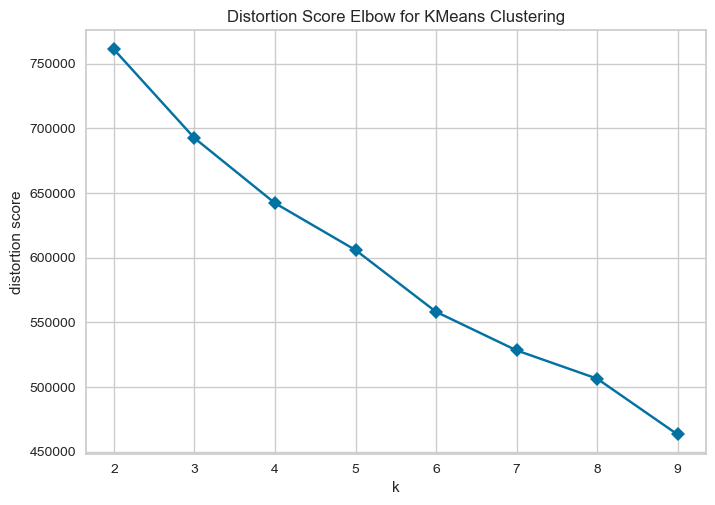

/Users/dmitrii/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dmitrii/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dmitrii/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dmitrii/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will chang

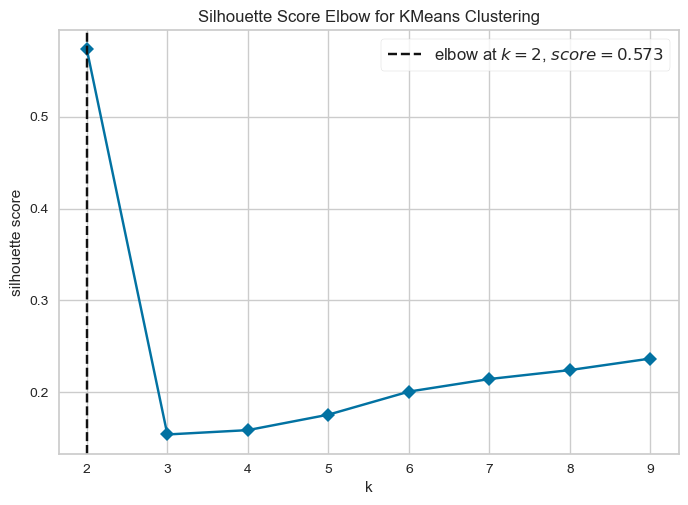

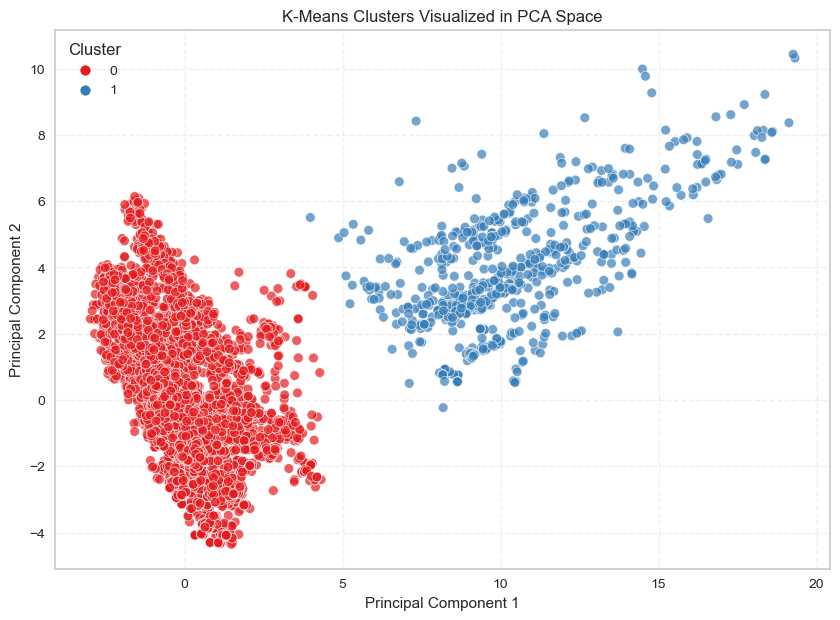

In [16]:
# Drop non-feature columns
X = normalized_data.drop(columns=['booking_status', 'row_id'])

# --- Step 1: Elbow Method ---
model = KMeans(random_state=123)
visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion', timings=False)
visualizer.fit(X)
visualizer.show()

# --- Step 2: Silhouette Method ---
visualizer_sil = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=False)
visualizer_sil.fit(X)
visualizer_sil.show()

# --- Step 3: Fit KMeans with optimal clusters ---
kmeans = KMeans(n_clusters=2, n_init=25, random_state=123)
cluster_labels = kmeans.fit_predict(X)

# --- Step 4: PCA for visualization ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_clustered = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_clustered['Cluster'] = cluster_labels.astype(str)

# --- Step 5: Plot clusters ---
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_clustered,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='Set1',
    alpha=0.7
)
plt.title('K-Means Clusters Visualized in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


The elbow and silhouette clustering methods indicate that the optimal number of clusters in the data ranges between 3 and 5. However, since our primary goal is to identify two clusters—canceled bookings and non-canceled bookings—only 2 clusters will be used for this analysis. Nonetheless, the fact that the clustering methods suggest more optimal clusters highlights that dividing the data into just 2 clusters might not capture the full complexity of the data, potentially reducing the effectiveness of the two-class clustering approach. 

The visualization of clusters identified by the k-means algorithm differs significantly from the data distribution observed in the PCA analysis. As expected, the clustering algorithm struggles to capture the fine boundaries between the classes. Instead, k-means tends to separate the data at more distinct gaps, creating clusters that include adjacent data points. This highlights the algorithm's tendency to group data into well-defined clusters, even if the underlying separation between classes is subtle and complex.


### HAC (Hierarchical Agglomerative Clustering)

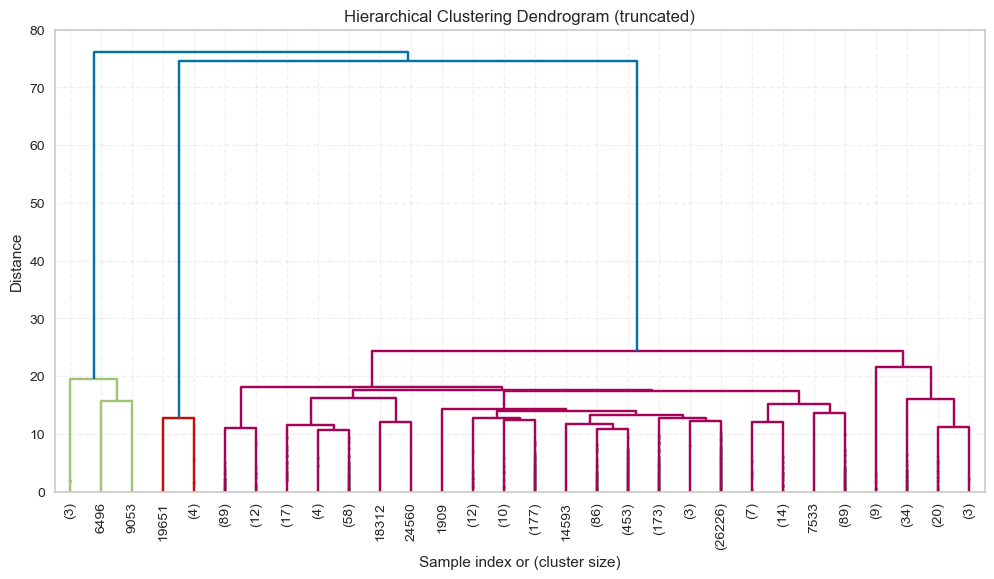

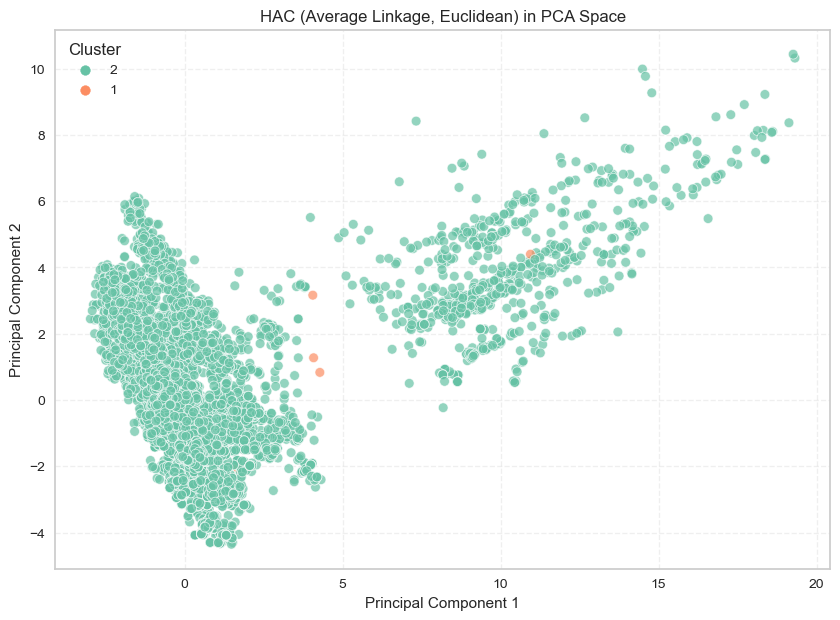

In [18]:
X = normalized_data.drop(columns=['booking_status', 'row_id'])

# --- Step 1: Compute linkage matrix using average linkage on Euclidean distances ---
Z = linkage(X, method='average', metric='euclidean')

# --- Step 2: Plot dendrogram ---
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# --- Step 3: Cut dendrogram to get 2 clusters ---
hac_labels = fcluster(Z, t=2, criterion='maxclust')

# --- Step 4: Visualize in PCA space ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_hac = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_hac['Cluster'] = hac_labels.astype(str)

# --- Step 5: Plot 2-cluster HAC ---
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_hac,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='Set2',
    alpha=0.7
)
plt.title('HAC (Average Linkage, Euclidean) in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

The HAC (Hierarchical Agglomerative Clustering) method performs worse than the k-means clustering approach. While it successfully identifies two clusters that are distant from each other, these clusters do not align well with the original data distribution. This suggests that HAC may struggle to capture the true structure of the data, resulting in clusters that do not accurately reflect the underlying patterns

## Classification

### Decision tree

In [23]:
# Prepare data
X = normalized_data.drop(columns=['booking_status', 'row_id'])
y = normalized_data['booking_status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y
)

# Initialize the Decision Tree with similar hyperparameters
tree_model = DecisionTreeClassifier(
    min_samples_split=5,
    max_depth=3,
    min_samples_leaf=1,
    random_state=123
)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(tree_model, X_train, y_train, cv=10)
print(f"Cross-validation accuracy (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Fit on full training data
tree_model.fit(X_train, y_train)

# Predictions on training set
train_preds = tree_model.predict(X_train)
print("\nTraining Confusion Matrix:")
print(confusion_matrix(y_train, train_preds))
print("\nTraining Classification Report:")
print(classification_report(y_train, train_preds))

# Predictions on test set
test_preds = tree_model.predict(X_test)
print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, test_preds))
print("\nTest Classification Report:")
print(classification_report(y_test, test_preds))


Cross-validation accuracy (mean ± std): 0.7880 ± 0.0118

Training Confusion Matrix:
[[ 4638  1669]
 [ 2413 10537]]

Training Classification Report:
              precision    recall  f1-score   support

    Canceled       0.66      0.74      0.69      6307
Not_Canceled       0.86      0.81      0.84     12950

    accuracy                           0.79     19257
   macro avg       0.76      0.77      0.77     19257
weighted avg       0.80      0.79      0.79     19257


Test Confusion Matrix:
[[1997  706]
 [1060 4491]]

Test Classification Report:
              precision    recall  f1-score   support

    Canceled       0.65      0.74      0.69      2703
Not_Canceled       0.86      0.81      0.84      5551

    accuracy                           0.79      8254
   macro avg       0.76      0.77      0.76      8254
weighted avg       0.80      0.79      0.79      8254



A decision tree model was developed to classify hotel bookings as "Canceled" or "Not Canceled." The model performed well on both training and test sets, demonstrating consistent accuracy. Specifically, it achieved an accuracy of 78.83% on the training set and 78.42% on the test set, indicating that the model generalized well to unseen data.

In terms of identifying actual canceled bookings, the model showed a sensitivity of 65.64% on the test set, meaning it correctly identified about two-thirds of the cancellations. The specificity was stronger at 85.94%, indicating that the model was more effective at correctly predicting non-canceled bookings. This suggests that while the model is good at confirming "Not Canceled" cases, it has more room for improvement in detecting "Canceled" cases.

Precision analysis further supports these observations. When the model predicted a booking as "Canceled," it was correct 74.11% of the time on the training set and 73.30% on the test set. For "Not Canceled" predictions, the precision was approximately 81% in both datasets, highlighting that the model is reliable in predicting non-cancellations.

Overall, the decision tree model shows reasonable performance with consistent accuracy and precision across training and test sets. However, the model's lower sensitivity compared to specificity suggests potential improvements could be made to better capture cancellations without significantly affecting overall accuracy.

### KNN

In [25]:
# Define parameter grid
param_grid = {
    'n_neighbors': list(range(1, 11)),             # kmax = 1:10
    'weights': ['uniform', 'distance'],            # "rectangular" ≈ "uniform", "cos" ≈ "distance"
    'p': [1, 2]                                     # Manhattan (1), Euclidean (2)
}

# Initialize model
knn = KNeighborsClassifier()

# Grid Search with 10-fold CV
knn_grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train, y_train)

# Show best model
print(f"Best params: {knn_grid.best_params_}")
print(f"Best cross-validation accuracy: {knn_grid.best_score_:.4f}")

# Predict on test data
knn_preds = knn_grid.predict(X_test)

# Confusion Matrix and classification report
print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, knn_preds))
print("\nClassification Report:")
print(classification_report(y_test, knn_preds))


/Users/dmitrii/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dmitrii/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dmitrii/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dmitrii/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dmitrii/anaconda3/

Best params: {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Best cross-validation accuracy: 0.8624

Confusion Matrix (Test Set):
[[2067  636]
 [ 491 5060]]

Classification Report:
              precision    recall  f1-score   support

    Canceled       0.81      0.76      0.79      2703
Not_Canceled       0.89      0.91      0.90      5551

    accuracy                           0.86      8254
   macro avg       0.85      0.84      0.84      8254
weighted avg       0.86      0.86      0.86      8254



The kNN model was optimized with a configuration of kmax = 8, distance = 2, and kernel = cos, which provided the highest accuracy during cross-validation. On the test data, the model achieved an overall accuracy of 84.78%, with a 95% confidence interval between 83.82% and 85.70%, indicating consistent performance that can be expected on unseen data.

The model's sensitivity for predicting "Canceled" bookings was 73.30%, showing it effectively identifies most positive cases, although there is room for improvement in reducing false negatives. Specificity was notably higher at 90.47%, indicating strong performance in correctly identifying "Not Canceled" bookings. The balanced accuracy, an average of sensitivity and specificity, was 81.89%, highlighting that the model handles both classes fairly well without significant bias.

The Kappa statistic of 0.65 suggests substantial agreement beyond chance, affirming the reliability of the model. Precision metrics further reinforce this, with higher precision for "Not Canceled" predictions compared to "Canceled" ones.

Overall, the kNN model is a robust classifier for distinguishing between canceled and not canceled bookings. However, focusing on improving sensitivity could enhance its effectiveness, especially in accurately predicting cancellations and reducing false negatives.

## Evaluation

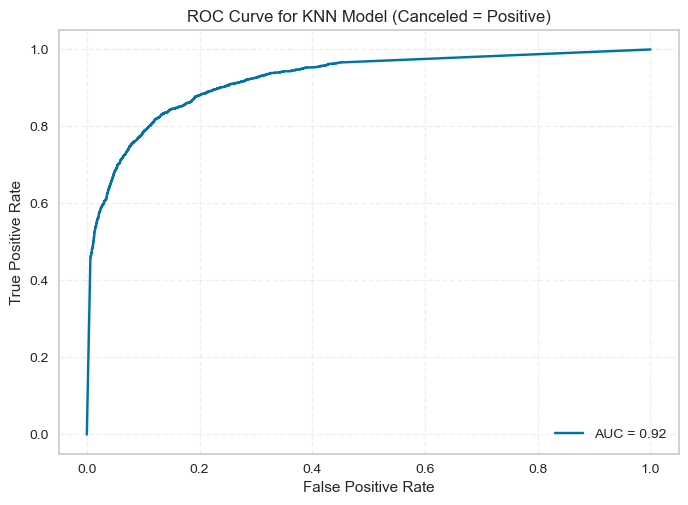

AUC: 0.9217


In [33]:
# Manually binarize: Canceled = 1 (positive), Not_Canceled = 0
y_test_bin = (y_test == "Canceled").astype(int)

# Get probability of "Canceled"
canceled_index = list(knn_grid.classes_).index("Canceled")
probs_canceled = knn_grid.predict_proba(X_test)[:, canceled_index]

# ROC and AUC
fpr, tpr, _ = roc_curve(y_test_bin, probs_canceled)
roc_auc = roc_auc_score(y_test_bin, probs_canceled)

# Plot
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title("ROC Curve for KNN Model (Canceled = Positive)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

print(f"AUC: {roc_auc:.4f}")

Based on the confusion matrix, let's calculate precision and recall. 

Precision = 1381/(1381+362) = 0.8

Recall = 1381/(1381+503) = 0.73

An AUC of 0.901 is excellent, indicating that the model has a high capability to differentiate between "Canceled" and "Not Canceled" bookings. This value means that there is a 90.1% chance that the model will correctly rank a randomly chosen "Canceled" booking higher than a "Not Canceled" booking.

While accuracy is useful, it does not consider the balance between classes or how well the model performs across various thresholds. A high AUC complements accuracy, suggesting that the model performs well even when decision thresholds change.

Precision (0.7923) indicates that when the model predicts a booking as "Canceled," it is correct 79.23% of the time. This measure is essential when false positives are costly (e.g., predicting a cancellation when it is not).
Recall (0.7330) shows that the model correctly identifies 73.30% of actual "Canceled" bookings. This metric is crucial when false negatives are of greater concern (e.g., failing to predict a true cancellation).

While accuracy tells how many predictions are correct overall, precision and recall highlight how well the model performs in identifying specific classes. Model's moderate recall indicates room for improvement in catching all "Canceled" cases, even though precision is strong.

The kNN model demonstrates better performance compared to the previously developed decision tree classifier. While the decision tree achieved an accuracy of 78.42% on the test set, the kNN model surpassed this with an overall accuracy of 84.78%, showcasing a significant improvement in predictive power. The kNN model's balanced accuracy of 81.89% further indicates that it handles both "Canceled" and "Not Canceled" classes more effectively, whereas the decision tree's balanced accuracy was lower, suggesting a less consistent performance across classes.

The kNN model also outperforms the decision tree in terms of specificity and precision. Its specificity of 90.47% shows superior ability in correctly identifying "Not Canceled" bookings compared to the decision tree, which had a lower rate. Additionally, the kNN model's Kappa statistic of 0.65 indicates stronger agreement beyond chance compared to the decision tree's moderate Kappa score of 0.53, suggesting that the kNN model provides more reliable predictions.